# Stacking
### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

### Create Dataframe

In [4]:
selected_features = pd.read_csv('data/selected_features.csv')
target_column = 'price actual'
y = selected_features[target_column]

Remove unwanted columns

In [5]:
try: 
    selected_features.drop(target_column, axis=1, inplace=True)
    selected_features.drop(target_column + ' ewm', axis=1, inplace=True)
except:
    print('Already dropped')

### Stacking Function

In [6]:
def Stacking(model, train, y, test, n_fold):
    folds = KFold(n_splits=n_fold)
    test_pred = np.empty((0, test.shape[0]), float)
    train_pred = np.empty((0), float)
    
    for train_indices, val_indices in folds.split(train):
        x_train, x_val = train.iloc[train_indices], train.iloc[val_indices]
        y_train, y_val = y.iloc[train_indices], y.iloc[val_indices]
        
        model.fit(X=x_train, y=y_train)
        train_pred = np.append(train_pred, model.predict(x_val))
        test_pred = np.vstack([test_pred, model.predict(test)])

    test_pred = test_pred.mean(axis=0).reshape(-1, 1)
    
    return test_pred, train_pred

### Hyperparameter tuning

In [7]:
x = selected_features[selected_features.columns]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

for basic_degree in range(2,8):
    mse_list = [[],[],[],[],[],[]]
    for n_fold in range(2,16):
        model1 = make_pipeline(PolynomialFeatures(basic_degree), LinearRegression())
        test_pred1 ,train_pred1 = Stacking(model = model1, n_fold = n_fold, train = x_train, test = x_test, y = y_train)
        train_pred1 = pd.DataFrame(train_pred1)
        test_pred1 = pd.DataFrame(test_pred1)

        model2 = LinearRegression()
        test_pred2, train_pred2 = Stacking(model = model2, n_fold = n_fold, train = x_train, test = x_test, y = y_train)
        train_pred2 = pd.DataFrame(train_pred2)
        test_pred2 = pd.DataFrame(test_pred2)

        df = pd.concat([train_pred1, train_pred2], axis=1)
        df_test = pd.concat([test_pred1, test_pred2], axis=1)

        for degree in range(2,8):
            meta_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
            meta_model.fit(df, y_train)
            y_pred = meta_model.predict(df_test)
            
            mse = mean_squared_error(y_test, y_pred)
            mse_list[degree-2].append(mse)
    

    plt.plot(range(2,16), mse_list[0], label=f'Meta degree 2')
    plt.plot(range(2,16), mse_list[1], label=f'Meta degree 3')
    plt.plot(range(2,16), mse_list[2], label=f'Meta degree 4')
    plt.plot(range(2,16), mse_list[3], label=f'Meta degree 5')
    plt.plot(range(2,16), mse_list[4], label=f'Meta degree 6')
    plt.plot(range(2,16), mse_list[5], label=f'Meta degree 7')
    plt.title(f'Basic degree {basic_degree}')
    plt.xlabel('Number of folds')
    plt.ylabel('MSE')
    plt.ylim(85, 105)
    plt.legend()
    plt.show()

KeyboardInterrupt: 

### Optimal Hyperparameters

Mean Squared Error (MSE): 87.18379159096132


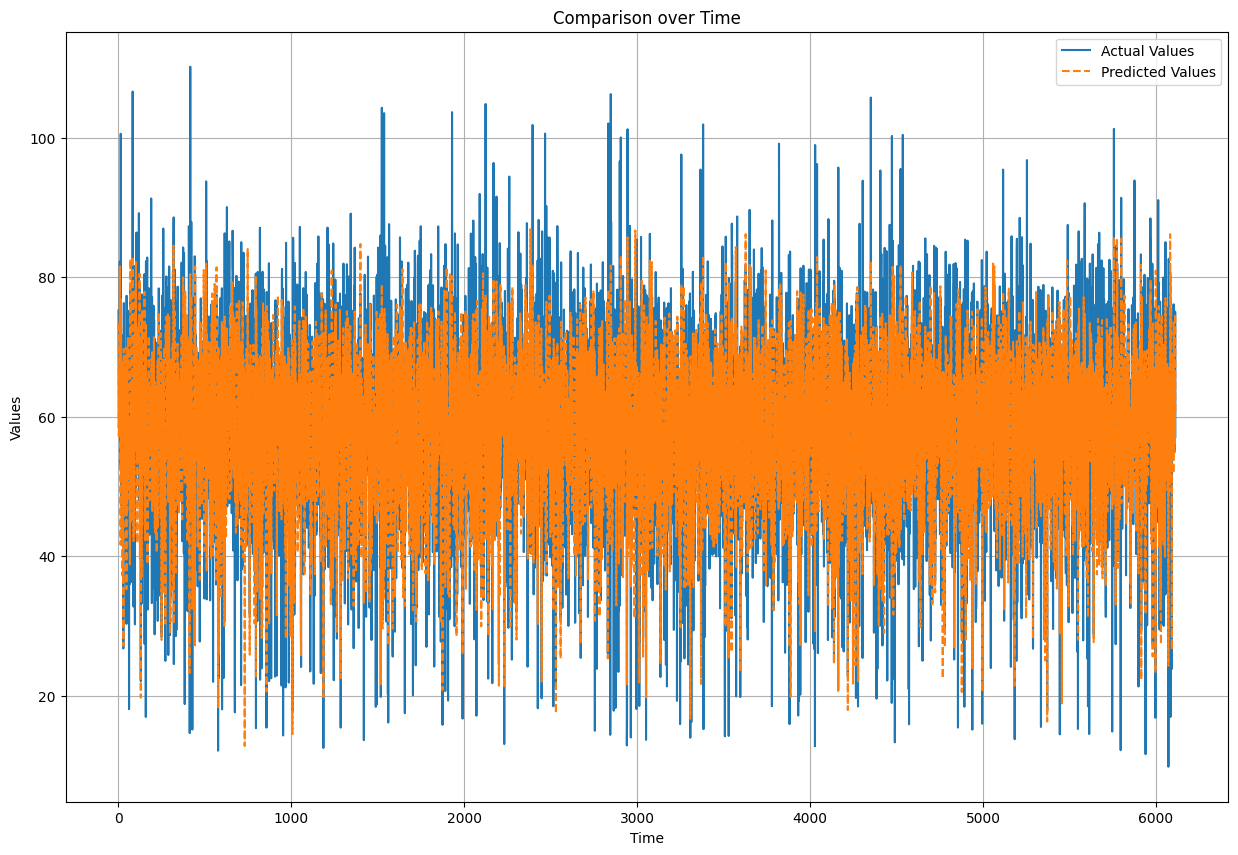

In [8]:
x = selected_features[selected_features.columns]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

degree = 4
model1 = make_pipeline(PolynomialFeatures(degree), LinearRegression())
test_pred1, train_pred1 = Stacking(model = model1, n_fold = 6, train = x_train, test = x_test, y = y_train)
train_pred1 = pd.DataFrame(train_pred1)
test_pred1 = pd.DataFrame(test_pred1)

model2 = LinearRegression()
test_pred2, train_pred2 = Stacking(model = model2, n_fold = 6, train = x_train, test = x_test, y = y_train)
train_pred2 = pd.DataFrame(train_pred2)
test_pred2 = pd.DataFrame(test_pred2)

df = pd.concat([train_pred1, train_pred2], axis=1)
df_test = pd.concat([test_pred1, test_pred2], axis=1)
meta_model = make_pipeline(PolynomialFeatures(5), LinearRegression())
meta_model.fit(df, y_train)
y_pred = meta_model.predict(df_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

plt.figure(figsize=(15, 10))
plt.plot(y_test.reset_index(drop=True), label='Actual Values')
plt.plot(y_pred, label='Predicted Values', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Comparison over Time')
plt.legend()
plt.grid(True)
plt.show()


### Save to CSV

In [9]:
stacking = pd.DataFrame(y_pred)
stacking.to_csv('data/stacking.csv', index=False, header=False)

### Tested with different base methods

Mean Squared Error (MSE): 55.53094638875078


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


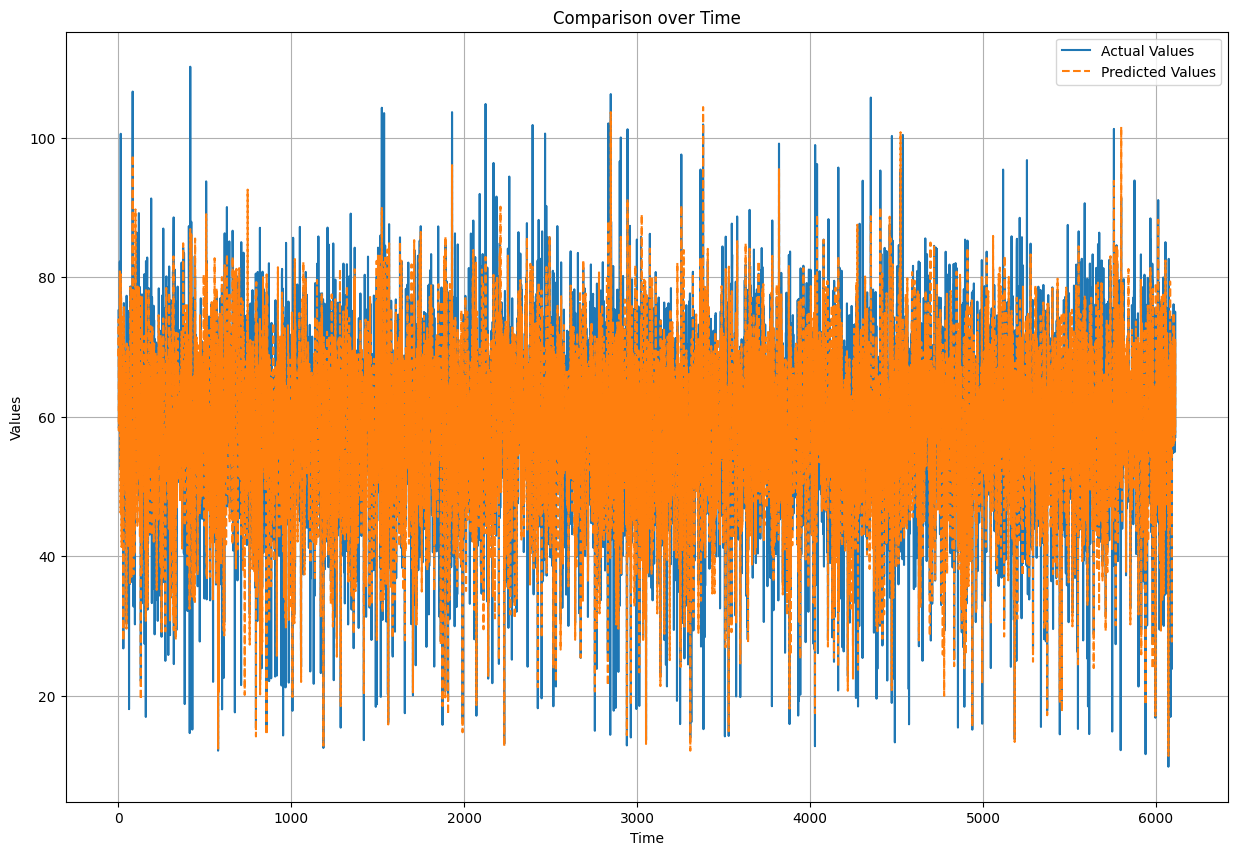

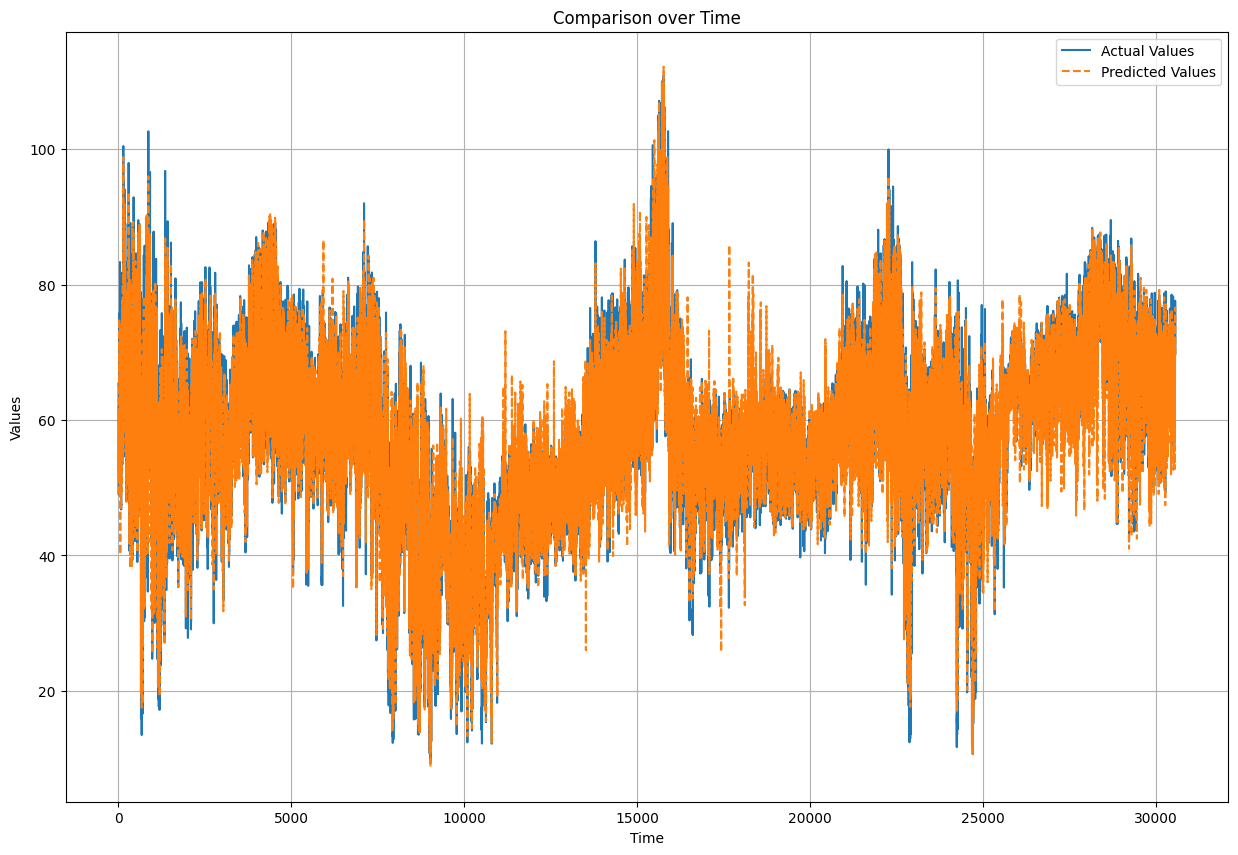

In [33]:
x = selected_features[selected_features.columns]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

degree = 4
model1 = RandomForestRegressor(random_state=42)
test_pred1 ,train_pred1 = Stacking(model=model1, n_fold=10, train=x_train, test=x_test, y=y_train)
train_pred1 = pd.DataFrame(train_pred1)
test_pred1 = pd.DataFrame(test_pred1)

model2 = DecisionTreeRegressor(random_state=42)
test_pred2, train_pred2 = Stacking(model=model2, n_fold=10, train=x_train, test=x_test, y=y_train)
train_pred2 = pd.DataFrame(train_pred2)
test_pred2 = pd.DataFrame(test_pred2)

df = pd.concat([train_pred1, train_pred2], axis=1)
df_test = pd.concat([test_pred1, test_pred2], axis=1)
meta_model = make_pipeline(PolynomialFeatures(5), LinearRegression())
meta_model.fit(df, y_train)
y_pred = meta_model.predict(df_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

test_pred1 = model1.predict(selected_features)
test_pred2 = model2.predict(selected_features)
df_original = pd.DataFrame({'Model1': test_pred1, 'Model2': test_pred2})
y_pred_original = meta_model.predict(df_original)

plt.figure(figsize=(15, 10))
plt.plot(y_test.reset_index(drop=True), label='Actual Values')
plt.plot(y_pred, label='Predicted Values', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Comparison over Time')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 10))
plt.plot(y, label='Actual Values')
plt.plot(y_pred_original, label='Predicted Values', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Comparison over Time')
plt.legend()
plt.grid(True)
plt.show()

### Comparison of Methods

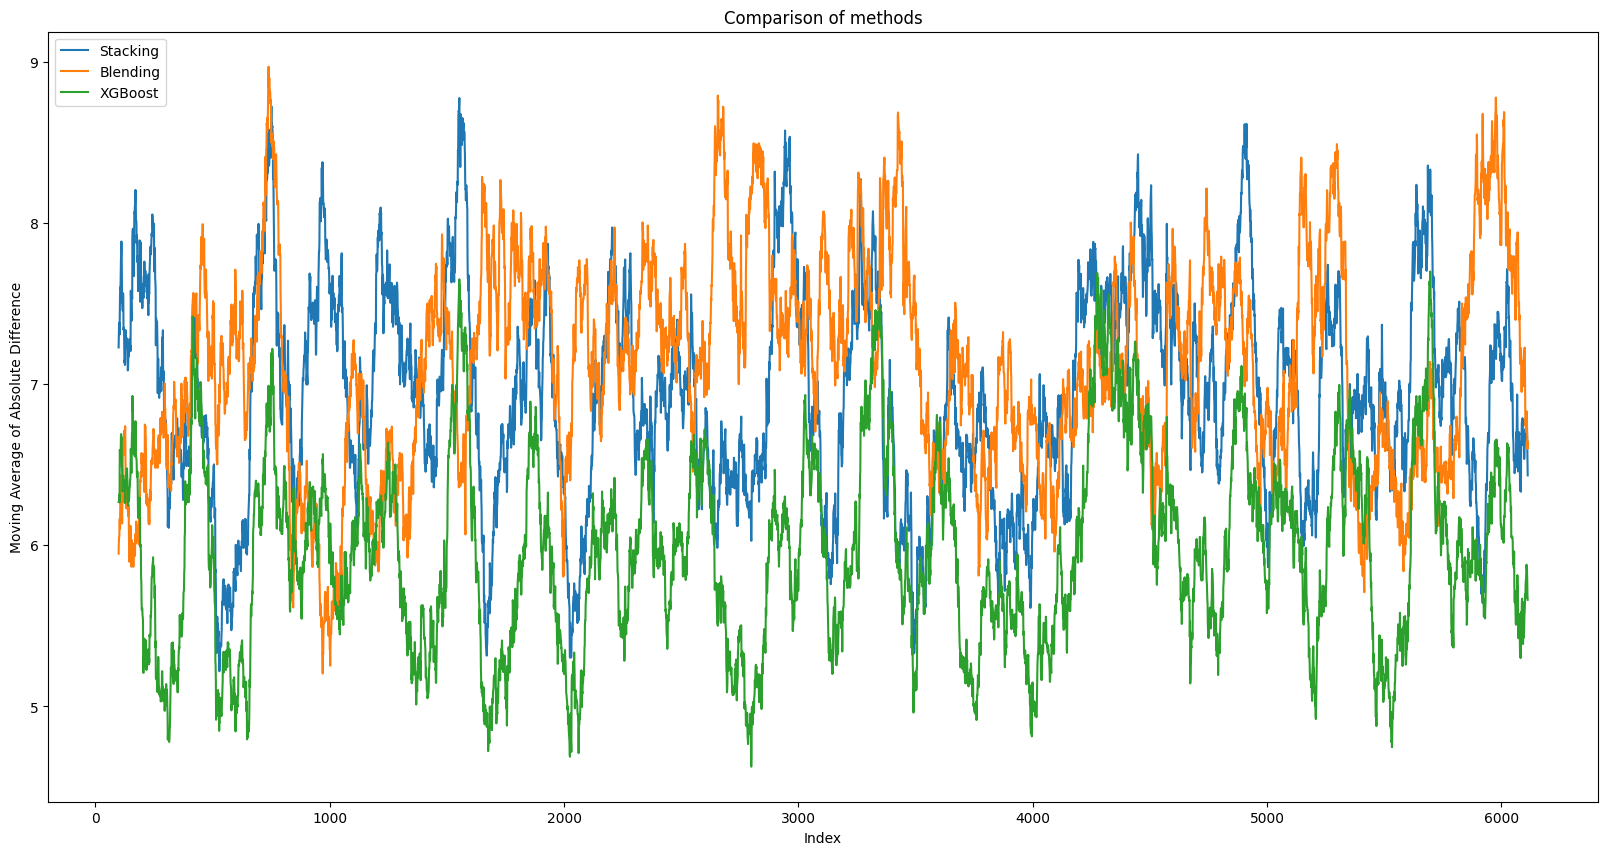

In [44]:
stacking = pd.read_csv('data/stacking.csv', header=None)
blending = pd.read_csv('data/blending.csv', header=None)
xgb = pd.read_csv('data/xgb.csv', header=None)

diff_stacking = abs(y_test.values - stacking[0])
diff_blending = abs(blending[1] - blending[0])
diff_xgb = abs(y_test.values - xgb[0])

window_size = 100
ma_diff_stacking = diff_stacking.rolling(window=window_size).mean()
ma_diff_blending = diff_blending.rolling(window=window_size).mean()
ma_diff_xgb = diff_xgb.rolling(window=window_size).mean()

plt.figure(figsize=(20, 10))
plt.title('Comparison of methods')
plt.plot(ma_diff_stacking, label='Stacking')
plt.plot(ma_diff_blending, label='Blending')
plt.plot(ma_diff_xgb, label='XGBoost')
plt.xlabel('Index')
plt.ylabel('Moving Average of Absolute Difference')
plt.legend()
plt.show()
